# ADAmax Milestone 2

In this notebook we briefly describe the data. Then we present the first analysis of tvtropes effect and competition effect. Those two part are to confirm our project is doable and how we will handle our research question. At last we present our attempt to analyse the movie plots based on an NLP model.

Structure of the respository:


 - data/
      - Imdb/
      - MovieSummaries/
 - src/
      - initial_analysis.ipynb
      - helpers.py
      - preprocess.py

## The Big Flop

### Initial preprocess (only run once)

The preprocess works like this:
  - One of the movie has a released date in 1010 and that is not possible. After checking on the web, the released date was in 2010.
  - To take into account the inflation, we create the features **adj_budjet**, **adj_revenue**, ... that are the the values of budget and revenue ajusted with the inflation. 

In [1]:
# from preprocess import preprocess

# preprocess()

### Getting the data

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pickle

from sklearn.decomposition import PCA
from helpers import *
from IPython.display import display

import warnings
warnings.filterwarnings("ignore")

In the CMU dataset, we have basic features like revenue, movie titles, genres, etc. In the IMDb dataset, there are a lot of additional features like budget, producer information, and user ratings.

Initially, there is no common key (column to merge) for the two datasets. Fortunately, for almost all of the Freebase IDs, we were able to find corresponding IMDb IDs.

In this notebook, we only consider the merged dataset (and any of its derivations).

There are features with the same name in both datasets, but they are not identical in values. For example, the movie runtimes can be different between the two datasets.

In [3]:
# Get the movie dataframe (merged from CMU and IMDb)
df_movies = get_movies()

display(df_movies.head(3))
display(df_movies.describe())


,wiki_id,freebase_id,name,box_office_revenue,runtime_x,languages,countries,adj_revenue_x,imdb_id,adult,...,title,video,vote_average,vote_count,adj_revenue_y,adj_budget,adj_profit,genres,year,release_date
0,975900,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",2.143713e+07,tt0228333,False,...,Ghosts of Mars,False,4.8,299.0,2.143713e+07,4.284111e+07,-2.140398e+07,"{Thriller, Horror, Science Fiction, Space west...",2001.0,2001-08-24
1,9363483,/m/0285_cd,White Of The Eye,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}",NaN,tt0094320,False,...,White of the Eye,False,5.7,15.0,0.000000e+00,0.000000e+00,0.000000e+00,"{Thriller, Horror, Erotic thriller, Psychologi...",1987.0,1987-01-01
2,6631279,/m/0gffwj,Little city,NaN,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",NaN,tt0119548,False,...,Little City,False,6.0,1.0,0.000000e+00,0.000000e+00,0.000000e+00,"{Romantic drama, Ensemble Film, Romantic comed...",1997.0,1997-04-04


,wiki_id,box_office_revenue,runtime_x,adj_revenue_x,revenue,runtime_y,vote_average,vote_count,adj_revenue_y,adj_budget,adj_profit,year
count,2.601100e+04,6.953000e+03,24768.000000,6.925000e+03,2.601100e+04,25990.000000,26011.000000,26011.000000,2.591300e+04,2.591300e+04,2.591300e+04,25361.000000
mean,1.201912e+07,5.177056e+07,99.855045,9.929178e+07,1.411799e+07,97.956907,5.823440,131.700896,2.547546e+07,8.693101e+06,1.678236e+07,1985.193052
std,1.068013e+07,1.145230e+08,28.824344,2.471029e+08,6.811600e+07,31.965146,1.591846,533.528543,1.326382e+08,2.798300e+07,1.195633e+08,24.028646
min,3.217000e+03,1.000000e+04,0.000000,1.242662e+04,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,-8.363272e+08,1890.000000
25%,2.641520e+06,2.604414e+06,89.000000,8.762023e+06,0.000000e+00,88.000000,5.300000,5.000000,0.000000e+00,0.000000e+00,0.000000e+00,1970.000000
50%,8.494848e+06,1.282632e+07,97.000000,2.969312e+07,0.000000e+00,97.000000,6.100000,13.000000,0.000000e+00,0.000000e+00,0.000000e+00,1993.000000
75%,2.078840e+07,4.661621e+07,110.000000,9.379987e+07,0.000000e+00,109.000000,6.800000,48.000000,0.000000e+00,0.000000e+00,0.000000e+00,2005.000000
max,3.737388e+07,2.782275e+09,1003.000000,7.828022e+09,2.787965e+09,931.000000,10.000000,14075.000000,7.801138e+09,8.363272e+08,7.723161e+09,2016.000000


### Detection of the box-office bombs

#### Using the list from tvtropes.org

In [4]:
import tropes

df_tropes = tropes.merge_cmu_with_tvtropes(df_movies, tropes.get_tvtropes_movies("../data/tvtropes_20200302.json"))
df_tropes = tropes.add_bob_indicator(df_tropes)

print(f"""Among the {len(df_movies)} in the IMDb dataset, {len(df_tropes)} have trope information
({len(df_tropes)/len(df_movies)*100:.1f})%.
Out of those, {df_tropes["is_bomb_tvtropes"].sum()} are bombs (contain the trope 'BoxOfficeBomb')
({df_tropes["is_bomb_tvtropes"].sum()/len(df_tropes)*100:.1f}%).""")

df_tropes.head(3)

Among the 26011 in the IMDb dataset, 6614 have trope information
(25.4)%.
Out of those, 1351 are bombs (contain the trope 'BoxOfficeBomb')
(20.4%).


,wiki_id,freebase_id,name,box_office_revenue,runtime_x,languages,countries,adj_revenue_x,imdb_id,adult,...,vote_average,vote_count,adj_revenue_y,adj_budget,adj_profit,genres,year,release_date,trope,is_bomb_tvtropes
0,975900,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",2.143713e+07,tt0228333,False,...,4.8,299.0,2.143713e+07,4.284111e+07,-2.140398e+07,"{Thriller, Horror, Science Fiction, Space west...",2001.0,2001-08-24,"[demonicpossession, starderailingrole, dugtood...",True
1,77856,/m/0kcn7,Mary Poppins,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",8.939626e+08,tt0058331,False,...,7.4,1217.0,8.939626e+08,5.244581e+07,8.415168e+08,"{Family, Fantasy, Drama, Comedy, Musical, Chil...",1964.0,1964-08-27,"[crushparade, onescenewonder, comicstrip, diso...",True
2,9548445,/m/02pjlrp,Archie: To Riverdale and Back Again,NaN,100.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",NaN,tt0099054,False,...,5.5,1.0,0.000000e+00,0.000000e+00,0.000000e+00,"{Comedy, TV Movie}",1990.0,1990-05-06,"[relativeerror, notallowedtogrowup, playedforl...",False


The variable `is_bomb_tvtropes` is one of the indicators of the failure of a movie. This is a good indicator as it is based on "expert opinion": tvtropes users, who has domain knowledge on the movie industry. However, we only know this information for a fraction of all the movies in our big dataset. 

#### Using the budget feature in IMDb datas

We don't really know the real revenue of the production companies for each movies. But we know a proxy of it : the box office revenue. Therefore a creteria for beeing a box office bomb can be $revenue-budget<0$

In [5]:
# Compute that criteria
df_movies["is_bomb_profit"] = df_movies["adj_profit"] < 0

print(f"""Among the {len(df_movies)} in the IMDb dataset, {df_movies["is_bomb_profit"].sum()} are bombs.
    That represents {df_movies["is_bomb_profit"].sum()/len(df_movies)*100:.1f}% of the dataset
    And {df_movies["is_bomb_profit"].sum()/len(df_movies[~df_movies["adj_profit"].isna()])*100:.1f}% of movies that we know the profit
""")


Among the 26011 in the IMDb dataset, 3312 are bombs.
    That represents 12.7% of the dataset
    And 12.8% of movies that we know the profit



#### Using the reviews in IMDb datas

We decide that a movie have bad reviews if its average review is lower than the 10% quantile of all average reviews

In [6]:
df_movies["is_bomb_reviews"] =  df_movies["vote_average"] < df_movies["vote_average"].quantile(0.1)

print(f"""Among the {len(df_movies)} in the IMDb dataset, {df_movies["is_bomb_reviews"].sum()} are bombs.
    That represents {df_movies["is_bomb_reviews"].sum()/len(df_movies)*100:.1f}% of the dataset
    And {df_movies["is_bomb_reviews"].sum()/len(df_movies[~df_movies["vote_average"].isna()])*100:.1f}% of movies that we know the average review 
""")

Among the 26011 in the IMDb dataset, 2568 are bombs.
    That represents 9.9% of the dataset
    And 9.9% of movies that we know the average review 



### The genres that contain the most bombs

We processed the genres from 300 diferrent genres to 200 genres. We did that by saying for example that if a movie is a Romance Comedy then it is a Romance and a Comedy.

Then we have one hot encoded the presence of each genre in the movies. the result is stored in the dataframe **genres.csv** (this file is generated by the notebook `genres_study.ipynb`).

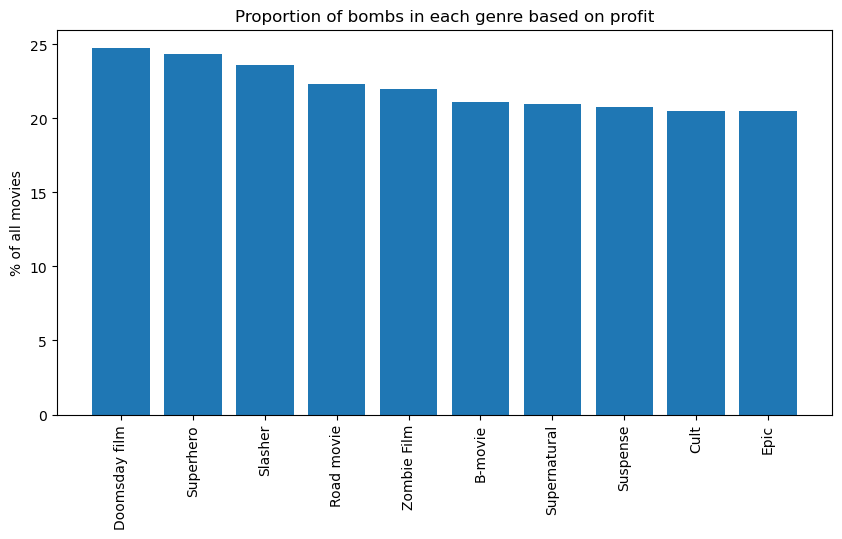

In [7]:
# Read the dataframe
df_genre = pd.read_csv("../data/MovieSummaries/genres.csv", index_col=0)

# Merge with the computed bombs
df_genre = df_genre.merge(df_movies[["wiki_id", "is_bomb_profit", "is_bomb_reviews"]], on="wiki_id")

genre_names = list(set(df_genre.columns).difference(["wiki_id", "freebase_id", "name", "is_bomb_profit", "is_bomb_reviews"]))
count_ratio = []
count_total = []
for gn in genre_names:
    count_failures = df_genre[df_genre["is_bomb_profit"]][gn].sum()
    total = df_genre[gn].sum()
    count_total.append(total)
    count_ratio.append(count_failures / total)

genre_names = np.array(genre_names)
count_ratio = np.array(count_ratio)
count_total = np.array(count_total)

genre_names, count_ratio = genre_names[count_total > 100], count_ratio[count_total > 100]

genre_names = genre_names[np.argsort(-count_ratio)]
count_ratio = count_ratio[np.argsort(-count_ratio)]

plt.figure(figsize=(10, 5))
plt.bar(genre_names[:10], count_ratio[:10]*100)
plt.xticks(rotation=90)
plt.title("Proportion of bombs in each genre based on profit")
plt.ylabel("% of all movies")
plt.show()

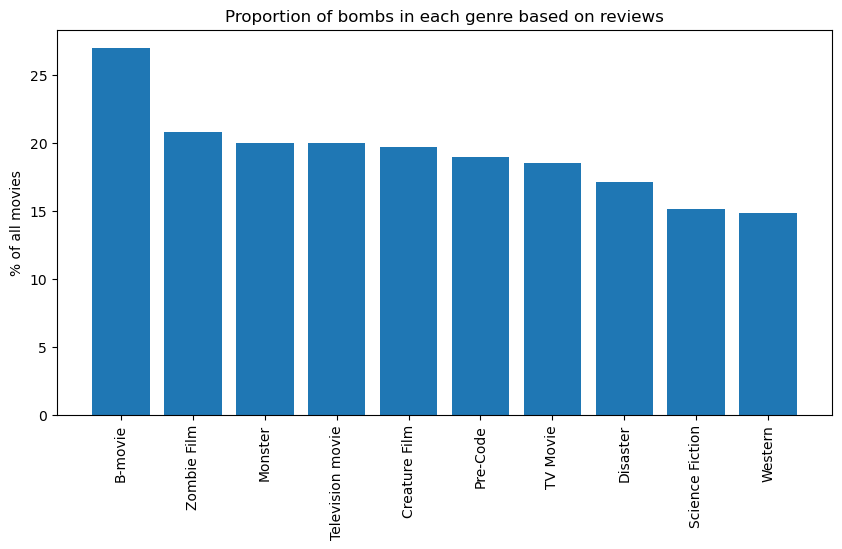

In [8]:
# Same figure considering bar reviews as beeing a failure
count_ratio = []
count_total = []
for gn in genre_names:
    count_failures = df_genre[df_genre["is_bomb_reviews"]][gn].sum()
    total = df_genre[gn].sum()
    count_total.append(total)
    count_ratio.append(count_failures / total)

genre_names = np.array(genre_names)
count_ratio = np.array(count_ratio)
count_total = np.array(count_total)

genre_names, count_ratio = genre_names[count_total > 100], count_ratio[count_total > 100]

genre_names = genre_names[np.argsort(-count_ratio)]
count_ratio = count_ratio[np.argsort(-count_ratio)]

plt.figure(figsize=(10, 5))
plt.bar(genre_names[:10], count_ratio[:10]*100)
plt.title("Proportion of bombs in each genre based on reviews")
plt.ylabel("% of all movies")
plt.xticks(rotation=90)
plt.show()


There are bad movies in every genre but here we have obtained the genres that contains the greatest proportions of failures. And the two list we obtained look very plausible. We can easyly think of a Zombie movie that must be a failure in terms of profit. But now we will analyse more precisely what could make a movie fail.

### Initial analysis of tvtropes effect

For this part, the goal is to explore the associations between the presence of tropes and the indication of box-office bombs. This could be done by doing a logistic regression of the `is_bomb_tvtropes` variable on the one-hot encodings of the tropes and look at the coefficients and the p-values.

In [9]:
# Retrieve all the tropes from the movies in the dataset
all_tropes = [tr for tropes in df_tropes["trope"].values for tr in tropes if tr != "boxofficebomb"]
# Retrieve all  the tropes from the box-office bomb movies in the dataset
all_tropes_bombs = [tr for tropes in df_tropes["trope"].values for tr in tropes if "boxofficebomb" in tropes and tr != "boxofficebomb"]

# counts the number of movies in each trope
from collections import Counter
counts = Counter(all_tropes)
counts_bombs = Counter(all_tropes_bombs) # only consider bombs

def normalize_counts(counts, normalizing_const=None):
    """Divide the counts by the number of movies
    """
    if normalizing_const is None:
        normalizing_const = sum(counts.values(), 0.0)
    for key in counts:
        counts[key] /= normalizing_const
        counts[key] *= 100
    return counts

def count_movies_with_trope_is_bomb(df_tropes, trope):
    i = 0
    for trope_list in df_tropes["trope"]:
        if trope in trope_list and "boxofficebomb" in trope_list:
            i += 1
    return i

# normalize by the number of movies
counts_n = normalize_counts(counts, df_tropes.shape[0])
counts_bombs_n = normalize_counts(counts_bombs, df_tropes["is_bomb_tvtropes"].sum())

res_all = {}
for k, v in counts.most_common(100):
    res_all[k] = v

top_tropes = list(res_all.keys())

res_bombs = {}
for k, v in counts_bombs.most_common(100):
    res_bombs[k] = v

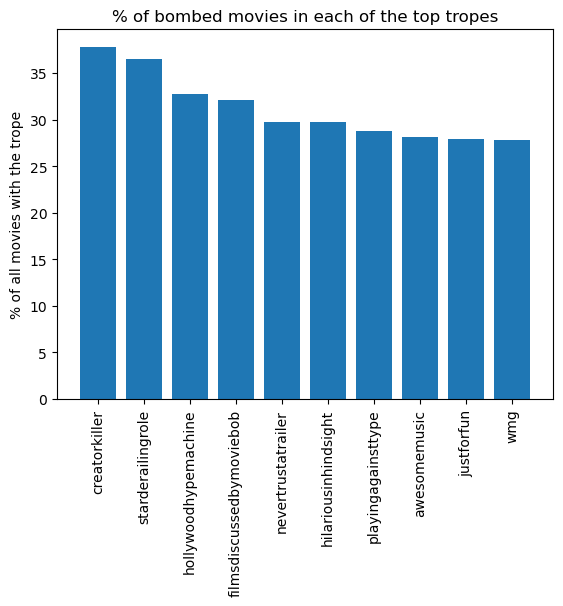

In [10]:
dict_plot = {}
for i, trope in enumerate(top_tropes):
    dict_plot[trope] = count_movies_with_trope_is_bomb(df_tropes, trope) / res_all[trope]
dict_plot = {k: v for k, v in sorted(dict_plot.items(), key=lambda item: item[1], reverse=True)}

plt.bar(list(dict_plot.keys())[:10], list(dict_plot.values())[:10])
plt.xticks(rotation=90)
plt.ylabel("% of all movies with the trope")
plt.title("% of bombed movies in each of the top tropes")
plt.show()

Comment: These tropes are the ones that contain the most bombed movies. We can see that these tropes make a lot of sense when one checks their definitions on tvtropes.org.

In [11]:
features_list = top_tropes

trope_ind_mat = np.zeros((len(df_tropes), len(features_list)))

for i, trope in enumerate(features_list):
    trope_indicator = []
    for trope_list in df_tropes["trope"].values:
        trope_indicator.append(trope in trope_list)
    trope_ind_mat[:, i] = trope_indicator
trope_ind_mat = pd.DataFrame(trope_ind_mat, columns=features_list)

model = sm.Logit(df_tropes["is_bomb_tvtropes"].values, sm.add_constant(trope_ind_mat))
res = model.fit()

res.params[res.pvalues[res.pvalues < 0.05/100].index].sort_values(ascending=False)

Optimization terminated successfully.
         Current function value: 0.394772
         Iterations 7


filmsof19951999             1.526806
filmsof20102014             1.510760
filmsof19901994             1.281414
filmsof20002004             1.257467
filmsof20052009             1.056762
creatorkiller               1.011661
americanfilms               0.990212
starderailingrole           0.948062
filmsofthe1980s             0.868915
filmsdiscussedbymoviebob    0.650744
troubledproduction          0.517095
playingagainsttype          0.504126
horrorfilms                -0.920257
const                      -3.426758
dtype: float64

Unhide the cell below to see the full results of the regression. In short, there are a few tropes that have strong effects (possibly causal) on the failure of the movie, but these tropes are not present in the trope plot above.

#### Full results of the regression

In [12]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 6614
Model:                          Logit   Df Residuals:                     6513
Method:                           MLE   Df Model:                          100
Date:                Fri, 18 Nov 2022   Pseudo R-squ.:                  0.2202
Time:                        22:17:13   Log-Likelihood:                -2611.0
converged:                       True   LL-Null:                       -3348.4
Covariance Type:            nonrobust   LLR p-value:                3.399e-243
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -3.4268      0.131    -26.160      0.000      -3.684      -3.170
americanfilms                   0.9902      0.101      9.777      0.000       0.792       1.189
shoutout                       -0.0441      0.088     -0.501      0.616      -0.216       0.128
bigbad                          0.1076      0.099      1.083      0.279      -0.087       0.302
chekhovsgun                     0.1700      0.096      1.766      0.077      -0.019       0.359
ohcrap                          0.1246      0.103      1.216      0.224      -0.076       0.326
jerkass                        -0.2023      0.099     -2.042      0.041      -0.396      -0.008
foreshadowing                  -0.0891      0.106     -0.842      0.400      -0.296       0.118
titledrop                      -0.0468      0.103     -0.452      0.651      -0.250       0.156
horrorfilms                    -0.9203      0.139     -6.642      0.000      -1.192      -0.649
bittersweetending               0.0210      0.104      0.203      0.839      -0.182       0.224
deadpansnarker                 -0.1308      0.103     -1.268      0.205      -0.333       0.071
filmsofthe1980s                 0.8689      0.128      6.782      0.000       0.618       1.120
filmsof20052009                 1.0568      0.131      8.073      0.000       0.800       1.313
largeham                        0.2963      0.106      2.790      0.005       0.088       0.504
wmg                             0.2175      0.126      1.730      0.084      -0.029       0.464
tearjerker                     -0.1240      0.121     -1.025      0.305      -0.361       0.113
downerending                    0.1605      0.118      1.361      0.174      -0.071       0.392
nightmarefuel                   0.1356      0.133      1.019      0.308      -0.125       0.397
runninggag                      0.1780      0.112      1.589      0.112      -0.042       0.398
onewordtitle                    0.1383      0.111      1.251      0.211      -0.078       0.355
tagline                         0.1183      0.116      1.021      0.307      -0.109       0.346
imagesource                     0.1690      0.122      1.382      0.167      -0.071       0.409
headscratchers                 -0.3433      0.132     -2.591      0.010      -0.603      -0.084
whathappenedtothemouse         -0.0446      0.116     -0.386      0.699      -0.271       0.182
meaningfulname                 -0.0075      0.113     -0.066      0.947      -0.230       0.215
bookends                       -0.0503      0.114     -0.442      0.658      -0.273       0.173
fanservice                     -0.1455      0.121     -1.200      0.230      -0.383       0.092
thecameo                        0.2049      0.112      1.834      0.067      -0.014       0.424
completelydifferenttitle        0.0696      0.114      0.611      0.541      -0.153       0.293
filmsof20002004                 1.2575      0.134      9.378      0.000  

### Initial analysis of competition effect

It is intuitive to believe that the competition bewteen movies has an effect on the success or failure of a movie. But what is the competition?

#### Extract competition features

The features related to competition we are going to extract (for now) are :
 - the number of movies released the same week
 - the number of movies released the same month
 - the number of movies released the same year

 - the number of movies released the same week of the same genre
 - the number of movies released the same month of the same genre
 - the number of movies released the same year of the same genre

In [13]:
# Only keep movies with a release date
df_movies_rd = df_movies[~df_movies["release_date"].isna()]

# Count the number of movies per week, month, year 
for period in ["W", "M", "Y"]:
    df_movies_rd["period"] = df_movies_rd["release_date"].apply(lambda x: x.to_period(period))
    df_movies_rd["num_release_this_" + period] = df_movies_rd.groupby("period")["period"].transform("count")
df_movies_rd.drop(columns=["period"], inplace=True)

df_movies_genre_exploded = df_movies_rd.explode(column="genres")

# Count the number of movies per week, month, year of the same genre
for period in ["W", "M", "Y"]:
    df_movies_rd["num_release_this_" + period + "_of_this_genre"] = 0
    df_movies_rd["period"] = df_movies_rd["release_date"].apply(lambda x: x.to_period(period))
    df_movies_genre_exploded["period"] = df_movies_genre_exploded["release_date"].apply(lambda x: x.to_period(period))
    for genre in df_movies_genre_exploded["genres"].unique():
        # imdb_genres_df["num_release_this_" + period + "_of_this_genre"] = merge_df[merge_df["genres"] == genre].groupby("period")["period"].transform("count")
        counts = df_movies_genre_exploded[df_movies_genre_exploded["genres"] == genre].groupby("period")["id"].nunique()
        df_movies_rd["num_release_this_" + period + "_of_this_genre"] = df_movies_rd["period"].apply(lambda x: counts[x] if x in counts else 0)

df_movies_rd.drop(columns=["period"], inplace=True)
del df_movies_genre_exploded


#### Linear regression with competition features

Now we are going to train a linar model to predict wether a movie is a bomb or not using the previously extracted features. In that way we will ser the effect of competition or not on being a bomb.

After som features selection, we came out with the following model

In [14]:
# test_features = ["num_release_this_W", "num_release_this_M", "num_release_this_Y", "num_release_this_W_of_this_genre", "num_release_this_M_of_this_genre", "num_release_this_Y_of_this_genre"]
test_features = ["num_release_this_W_of_this_genre",  "num_release_this_Y_of_this_genre"]
control_features = ["adj_budget", "popularity", "vote_average", "vote_count", "num_release_this_W", "num_release_this_Y"]
target_features = ["is_bomb_profit", "is_bomb_reviews"]

# Get the features
x = df_movies_rd[test_features + control_features + target_features]
x.dropna(inplace=True)

y_profit = x["is_bomb_profit"]
y_reviews = x["is_bomb_reviews"]
x = x[test_features + control_features].astype(np.float32)
for f in x.columns:
    x[f] = (x[f] - x[f].min()) / (x[f].max() - x[f].min())

# Cast to float32
x = x.astype(np.float32)
y_reviews = y_reviews.astype(np.float32)
y_profit = y_profit.astype(np.float32)

# Fit the model
x =sm.add_constant(x)
print(len(x))

25270


##### Linear model that predict bombs based on profit

In [15]:
model = sm.OLS(y_profit, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         is_bomb_profit   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     404.4
Date:                Fri, 18 Nov 2022   Prob (F-statistic):               0.00
Time:                        22:22:20   Log-Likelihood:                -6740.1
No. Observations:               25270   AIC:                         1.350e+04
Df Residuals:                   25261   BIC:                         1.357e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                                0.0348      0.008      4.197      0.000       0.019       0.051
num_release_this_W_of_this_genre    -0.0522      0.040     -1.321      0.187      -0.130       0.025
num_release_this_Y_of_this_genre     0.0182      0.025      0.731      0.465      -0.031       0.067
adj_budget                           2.9056      0.076     38.044      0.000       2.756       3.055
popularity                           2.3204      0.113     20.544      0.000       2.099       2.542
vote_average                        -0.0346      0.013     -2.683      0.007      -0.060      -0.009
vote_count                          -2.7746      0.074    -37.252      0.000      -2.921      -2.629
num_release_this_W                  -0.0326      0.009     -3.791      0.000      -0.049      -0.016
num_release_this_Y                   0.1539      0.007     21.612      0.000       0.140       0.168
==============================================================================
Omnibus:                     8462.507   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            22318.386
Skew:                           1.858   Prob(JB):                         0.00
Kurtosis:                       5.719   Cond. No.                         77.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### Linear model that predict bombs based on reviews

In [16]:
model = sm.OLS(y_reviews, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        is_bomb_reviews   R-squared:                       0.580
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     4355.
Date:                Fri, 18 Nov 2022   Prob (F-statistic):               0.00
Time:                        22:22:20   Log-Likelihood:                 5784.6
No. Observations:               25270   AIC:                        -1.155e+04
Df Residuals:                   25261   BIC:                        -1.148e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                                0.9476      0.005    187.504      0.000       0.938       0.958
num_release_this_W_of_this_genre     0.0048      0.024      0.201      0.841      -0.042       0.052
num_release_this_Y_of_this_genre    -0.0178      0.015     -1.171      0.241      -0.047       0.012
adj_budget                          -0.4739      0.047    -10.185      0.000      -0.565      -0.383
popularity                          -0.4488      0.069     -6.523      0.000      -0.584      -0.314
vote_average                        -1.4236      0.008   -181.293      0.000      -1.439      -1.408
vote_count                           0.7241      0.045     15.960      0.000       0.635       0.813
num_release_this_W                   0.0271      0.005      5.173      0.000       0.017       0.037
num_release_this_Y                  -0.0383      0.004     -8.824      0.000      -0.047      -0.030
==============================================================================
Omnibus:                     6351.930   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15846.836
Skew:                           1.383   Prob(JB):                         0.00
Kurtosis:                       5.721   Cond. No.                         77.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Both models seem to capture some relationship between the features and the targets because their F-statistics are significant. In both models, grouping by genres do not seem to help, but no grouping provides significant features (the number of movies released in the same year and week). This means that the competition effect makes a movie more likely to fail (beacause the coefficients are positive).

### Quick study of the plots

In that part we used a pretrained language model in order to extract embeddings from movie plots.

We hoped that we could extract relevent informations from those embeddings. We first trained a SVM on the embeddings to predict if a movie is a bomb or not. The result was not conclusive.

Then we represented the embeddings in two dimensions in order to see if we identify clusters

In [17]:
with open("../data/MovieSummaries/plots_embeddings_mpnet.pkl", "rb") as f:
    plot_embeddings_mapping = pickle.load(f)

plots_df = get_plot_summaries()
plots_df = plots_df.merge(df_movies[["wiki_id", "is_bomb_profit", "is_bomb_reviews", "genres"]], on="wiki_id")

In [18]:
# Get a 2D representation of the plot embeddings
pca = PCA(n_components=2)
keys, embeddings = [], []
for k, e in plot_embeddings_mapping.items():
    keys.append(k)
    embeddings.append(e)

fitted_repr = pca.fit_transform(embeddings)
print("Explained variance ratio", sum(pca.explained_variance_ratio_))

plot_embeddings_mapping_x = {}
plot_embeddings_mapping_y = {}
for key, e in zip(keys, fitted_repr):
    plot_embeddings_mapping_x[key] = e[0]
    plot_embeddings_mapping_y[key] = e[1]

plots_df["x"] = plots_df["wiki_id"].map(plot_embeddings_mapping_x)
plots_df["y"] = plots_df["wiki_id"].map(plot_embeddings_mapping_y)


Explained variance ratio 0.08253500359329136


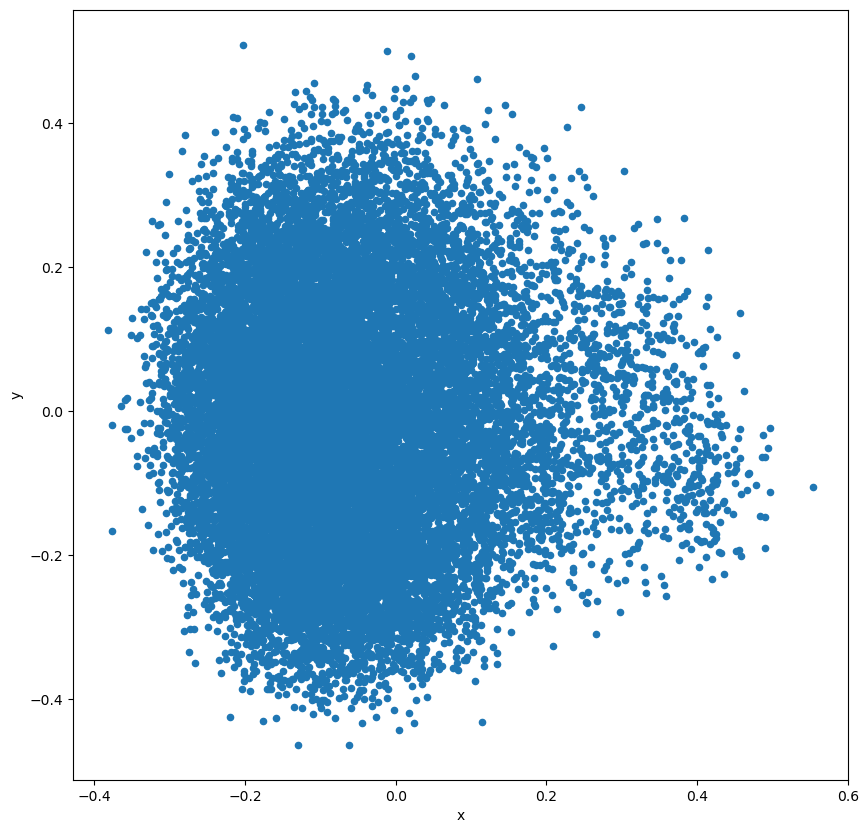

In [19]:
# Plot the 2D representation of the plot embeddings
plots_df.plot.scatter(x="x", y="y", figsize=(10, 10))
plt.show()

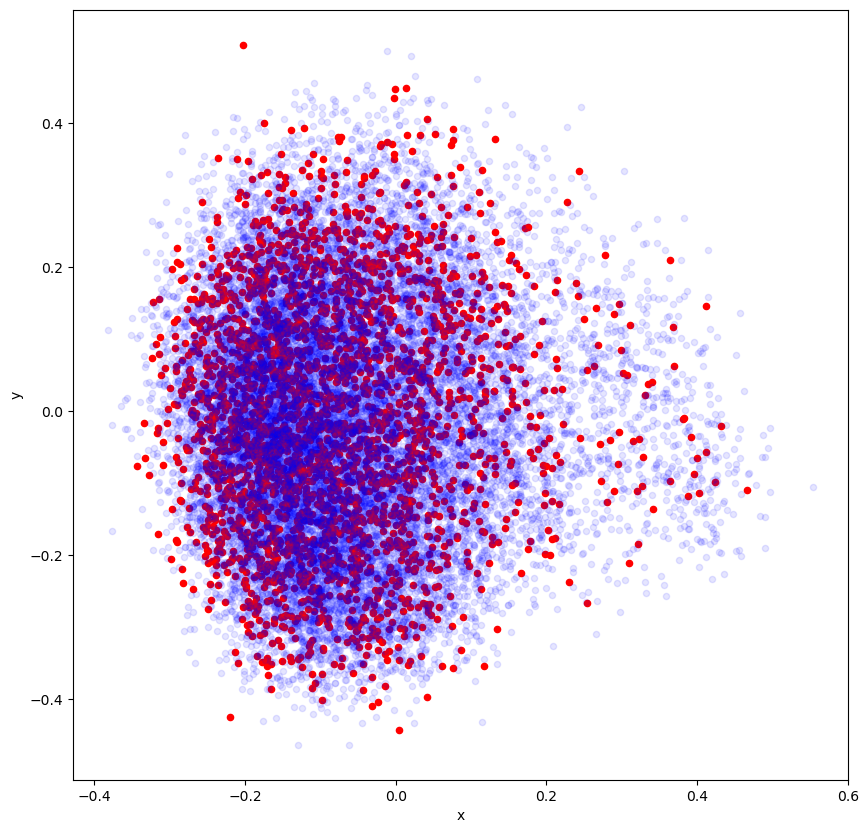

In [20]:
# Color by box office bomb
fig = plt.figure(figsize=(10, 10))
plots_df[plots_df["is_bomb_profit"]].plot.scatter(x="x", y="y", color="red", ax=fig.gca())
plots_df[~plots_df["is_bomb_profit"]].plot.scatter(x="x", y="y", color="blue", ax=fig.gca(), alpha=0.1)

plt.show()

We could not identify any obvious clusters, even after coloring the datapoints by our features (by genre, being a bomb or not, and by year).